<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04-2 전이 학습으로 영화 리뷰 텍스트의 감성 분류하기

*이 노트북은 코랩의 A100 GPU 런타임으로 테스트했습니다.*

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/04-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

04-1절에서 정의한 `transformer_encoder()` 함수를 재사용합니다.

In [1]:
# x는 토큰 임베딩과 위치 임베딩을 더한 값입니다.
def transformer_encoder(x, padding_mask, dropout, activation='relu'):
    residual = x
    key_dim = hidden_dim // num_heads
    # 멀티 헤드 어텐션을 통과합니다.
    x = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout)(
        query=x, value=x, attention_mask=padding_mask)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    residual = x
    # 위치별 피드 포워드 네트워크
    x = layers.Dense(hidden_dim * 4, activation=activation)(x)
    x = layers.Dense(hidden_dim)(x)
    x = layers.Dropout(dropout)(x)
    # 스킵 연결
    x = x + residual
    x = layers.LayerNormalization()(x)
    return x

## 트랜스포머 인코더 기반 언어 이해 모델 - BERT

In [2]:
import keras_nlp

# BERT 베이스
vocab_size = 30522
num_layers = 12
num_heads = 12
hidden_dim = 768
dropout = 0.1
activation = 'gelu'
max_seq_len = 512

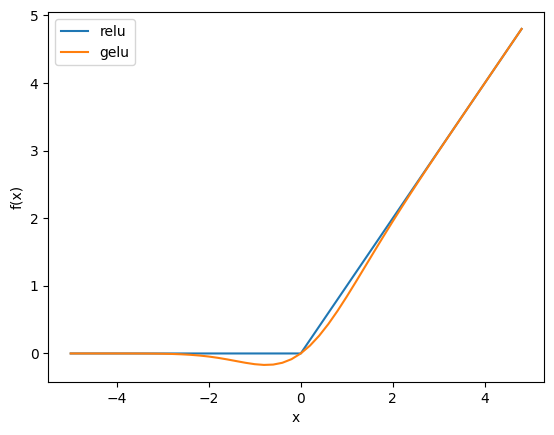

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf

def gelu(x):
    cdf = 0.5 * (1.0 + erf(x / np.sqrt(2.0)))
    return x * cdf

x = np.arange(-5, 5, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, gelu(x), label='gelu')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

In [4]:
import keras
from keras import layers

In [5]:
token_ids = keras.Input(shape=(None,))
segment_ids = keras.Input(shape=(None,))
padding_mask = keras.Input(shape=(None,))

token_embedding = layers.Embedding(vocab_size, hidden_dim)(token_ids)
pos_embedding = keras_nlp.layers.PositionEmbedding(max_seq_len)(token_embedding)
seg_embedding = layers.Embedding(2, hidden_dim)(segment_ids)

x = layers.Add()((token_embedding, pos_embedding, seg_embedding))
x = layers.LayerNormalization()(x)
x = layers.Dropout(dropout)(x)

for _ in range(num_layers):
    x = transformer_encoder(x, padding_mask, dropout, activation)

outputs = layers.Dense(hidden_dim, activation='tanh')(x[:,0,:])
model = keras.Model(inputs=(token_ids, segment_ids, padding_mask),
                    outputs=(outputs))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 768) │ 23,440,896 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 768) │    393,216 │ embedding[0][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 768) │      1,536 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 768) │          0 │ embedding[0][0],  │
│                     │                   │            │ position_embeddi… │
│                     │                   │            │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, None, 768) │      1,536 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 768) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 768) │  2,362,368 │ input_layer_2[0]… │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None, 768) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None, 768) │          0 │ dropout_2[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 768) │      1,536 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,362,368 │ layer_normalizat… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 768) │  2,360,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, None, 768) │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None, 768) │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 109,482,240 (417.64 MB)

 Trainable params: 109,482,240 (417.64 MB)

 Non-trainable params: 0 (0.00 B)

## KerasNLP로 영화 리뷰 텍스트의 감성 분류하기

### KerasNLP로 BERT 모델 로드하기

In [6]:
!gdown 15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
!tar -xzf aclImdb_v1.tar.gz
# 비지도 학습에 사용하는 데이터는 삭제합니다.
!rm -r aclImdb/train/unsup

Downloading...
From (original): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t
From (redirected): https://drive.google.com/uc?id=15ZSv_07b3HCKKn08jSDLl4JO4EFy8t-t&confirm=t&uuid=8bb506a9-1b7c-4e0e-b0a5-e9ff830d930e
To: /content/aclImdb_v1.tar.gz
100% 84.1M/84.1M [00:00<00:00, 89.5MB/s]


In [7]:
train_ds, val_ds = keras.utils.text_dataset_from_directory('aclImdb/train',
                                                           subset='both',
                                                           validation_split=0.2,
                                                           seed=42)
test_ds = keras.utils.text_dataset_from_directory('aclImdb/test')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [8]:
feature, target = train_ds.unbatch().take(1).get_single_element()
print(feature.numpy()[:100])
print(target.numpy())

b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell '
0


In [9]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=2
)

100%|██████████| 507/507 [00:00<00:00, 752kB/s]


In [10]:
classifier.summary()

Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                                │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │       4,385,920 │ padding_mask[0][0],        │
│                               │ None, 128)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ classifier_dropout (Dropout)  │ (None, 128)               │               0 │ bert_backbone[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │             258 │ classifier_dropout[0][0]   │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

### BERT 모델 미세 튜닝하기

In [11]:
classifier.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step - loss: 0.5763 - sparse_categorical_accuracy: 0.6862 - val_loss: 0.3593 - val_sparse_categorical_accuracy: 0.8472
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.3178 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.3058 - val_sparse_categorical_accuracy: 0.8724
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.2553 - sparse_categorical_accuracy: 0.8993 - val_loss: 0.2877 - val_sparse_categorical_accuracy: 0.8830
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.1998 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.3239 - val_sparse_categorical_accuracy: 0.8738
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1459 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.3484 - val_sparse_categorical_accuracy: 0.8804


In [12]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",
    num_classes=1,
    activation='sigmoid'
)

In [13]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.001)
classifier.compile(loss='binary_crossentropy',
                   optimizer=rmsprop,
                   metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)
hist = classifier.fit(train_ds, validation_data=val_ds, epochs=20,
                      callbacks=[early_stopping_cb])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 106ms/step - accuracy: 0.6017 - loss: 0.6304 - val_accuracy: 0.8060 - val_loss: 0.4430
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.8129 - loss: 0.4347 - val_accuracy: 0.8420 - val_loss: 0.3655
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.8532 - loss: 0.3605 - val_accuracy: 0.8656 - val_loss: 0.3279
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8734 - loss: 0.3163 - val_accuracy: 0.8824 - val_loss: 0.2929
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.8895 - loss: 0.2904 - val_accuracy: 0.8756 - val_loss: 0.3293
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9047 - loss: 0.2456 - val_accuracy: 0.8554 - val_loss: 0.3586
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.9294 - loss: 0.1963 - val_accuracy: 0.8844 - val_loss: 0.3063


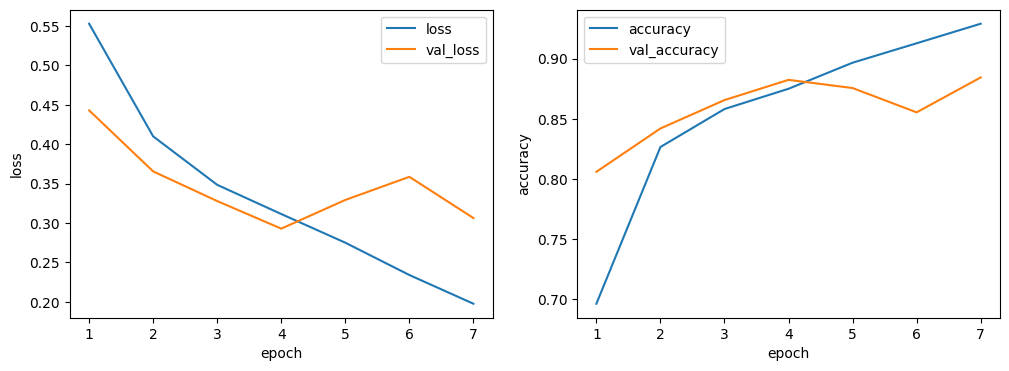

In [14]:
epochs = np.array(hist.epoch) + 1
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(epochs, hist.history['loss'], label='loss')
axs[0].plot(epochs, hist.history['val_loss'], label='val_loss')
axs[0].set_xticks(epochs)
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].legend()
axs[1].plot(epochs, hist.history['accuracy'], label='accuracy')
axs[1].plot(epochs, hist.history['val_accuracy'], label='val_accuracy')
axs[1].set_xticks(epochs)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].legend()
plt.show()

In [15]:
classifier.predict([feature])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


array([[0.65149015]], dtype=float32)

In [16]:
classifier.evaluate(test_ds)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8722 - loss: 0.3125


[0.313414990901947, 0.8718799948692322]

### 텍스트 전처리하기 - BERT 토크나이저

In [17]:
prep_data = classifier.preprocessor(feature)
print(len(prep_data['token_ids']), prep_data['token_ids'][:10])

512 tf.Tensor([  101  1000  6090  3207 26387  1000  2003  1037  5469  3185], shape=(10,), dtype=int32)


In [18]:
prep_data['token_ids'][-10:]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>

In [19]:
sum(prep_data['padding_mask'].numpy())

np.int64(197)

In [20]:
bert_tokenizer = classifier.preprocessor.tokenizer
bert_tokenizer.detokenize(prep_data['token_ids'][:10])

'[CLS] " pandemonium " is a horror movie'

In [21]:
tokens = []
for id in prep_data['token_ids'][:10]:
    tokens.append(bert_tokenizer.id_to_token(id))
print(tokens)

['[CLS]', '"', 'pan', '##de', '##monium', '"', 'is', 'a', 'horror', 'movie']


In [22]:
for token in tokens:
    print(bert_tokenizer.token_to_id(token), end=' ')

101 1000 6090 3207 26387 1000 2003 1037 5469 3185 

In [23]:
bert_tokenizer.tokenize('"pandemonium" is a horror movie')

<tf.Tensor: shape=(9,), dtype=int32, numpy=
array([ 1000,  6090,  3207, 26387,  1000,  2003,  1037,  5469,  3185],
      dtype=int32)>

## 허깅페이스로 영화 리뷰 텍스트의 감성 분류하기

### 네이버 영화 리뷰 데이터셋 준비하기

In [24]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [25]:
from datasets import load_dataset

nsmc = load_dataset("Blpeng/nsmc")

README.md:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


ratings_train.csv:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

ratings_test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [26]:
print(nsmc)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 50000
    })
})


In [27]:
# 불필요한 열 삭제 및 누락된 데이터 삭제
from datasets import DatasetDict

nsmc = nsmc.map(remove_columns=["Unnamed: 0"])
nsmc = DatasetDict({
    split: nsmc[split].filter(lambda x: x['document'] and x['document'].strip())
    for split in nsmc})

Map:   0%|          | 0/150000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/150000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [28]:
nsmc['train'][0]

{'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0}

### 백본 모델 선택하기

In [29]:
from transformers import AutoModelForSequenceClassification

bert_kor = AutoModelForSequenceClassification.from_pretrained(
    'bongsoo/bert-small-kor-v1',
    num_labels=2)

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bongsoo/bert-small-kor-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
print(bert_kor)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(10022, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-1

### 입력 데이터 토큰화하기

In [31]:
from transformers import AutoTokenizer

bert_kor_tokenizer = AutoTokenizer.from_pretrained('bongsoo/bert-small-kor-v1')

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/449 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

In [48]:
prep_data = bert_kor_tokenizer(nsmc['train'][0]['document'])
[key for key in prep_data.keys()]

['input_ids', 'token_type_ids', 'attention_mask']

In [33]:
prep_data['input_ids']

[2, 606, 261, 1519, 17, 17, 4668, 766, 1400, 1132, 1464, 1130, 2889, 3]

In [34]:
tokens = bert_kor_tokenizer.convert_ids_to_tokens(prep_data['input_ids'])
print(tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜', '##증', '##나', '##네', '##요', '목소리', '[SEP]']


In [35]:
bert_kor_tokenizer.convert_tokens_to_string(tokens)

'[CLS] 아 더빙.. 진짜 짜증나네요 목소리 [SEP]'

In [36]:
def tokenize(batch):
    return bert_kor_tokenizer(batch['document'], padding=True, truncation=True)

In [37]:
nsmc_tokenized = nsmc.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

In [38]:
print(nsmc_tokenized)

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49997
    })
})


In [39]:
nsmc_train = nsmc_tokenized["train"].shuffle(seed=42).select(range(1000))
nsmc_test = nsmc_tokenized["test"].shuffle(seed=42).select(range(100))

### BERT 모델 미세 튜닝하기

In [40]:
import evaluate

metric = evaluate.load("accuracy")

In [41]:
import numpy as np

def compute_metrics(eval_pred):
    # (100, 2), (100,)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [42]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir='bert_kor_nsmc',
                                  num_train_epochs=5,
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  logging_steps=len(nsmc_train)//8,
                                  load_best_model_at_end=True,
                                  report_to="none")

trainer = Trainer(model=bert_kor,
                  train_dataset=nsmc_train,
                  eval_dataset=nsmc_test,
                  args=training_args,
                  compute_metrics=compute_metrics)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.606500,0.487810,0.770000
2,0.435000,0.646783,0.730000
3,0.259400,0.560088,0.760000
4,0.149700,0.736437,0.800000
5,0.119800,0.743422,0.790000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=625, training_loss=0.3140804214477539, metrics={'train_runtime': 15.1843, 'train_samples_per_second': 329.288, 'train_steps_per_second': 41.161, 'total_flos': 54844270920000.0, 'train_loss': 0.3140804214477539, 'epoch': 5.0})

In [43]:
preds_output = trainer.predict(nsmc_test)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [44]:
print(preds_output.predictions[:7])
print(preds_output.label_ids[:7])

[[-0.01878525  0.54854167]
 [ 0.38593826 -0.44881523]
 [-0.22781618  0.46486023]
 [ 0.44338146 -0.81553596]
 [ 0.32361466  0.10407598]
 [ 0.05303202 -0.09903453]
 [-0.20270585  0.39513427]]
[0 0 1 1 0 0 0]


## 좀 더 알아보기

In [45]:
from transformers import pipeline

pipe = pipeline(task='text-classification', device=0,
                model='WhitePeak/bert-base-cased-Korean-sentiment')

config.json:   0%|          | 0.00/895 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [46]:
pipe('아 더빙.. 진짜 짜증나네요 목소리')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[{'label': 'LABEL_0', 'score': 0.997101366519928}]